In [35]:
#importing required libs
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_selection import VarianceThreshold
from datetime import datetime
df = pd.read_csv(r'1806291.csv')
df.shape

(50000, 19)

In [36]:
df.head()
df[df['cust_number']=="0100034821"]

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen
0,CA02,0100034821,17135 systems,2019-05-03 00:00:00,2019.0,2.960542e+09,2019-04-15,20190415,20190415,20190427.0,CAD,RV,1.0,NaN,18960.00,20190417.0,CA10,2.960542e+09,0
6314,CA02,0100034821,17135 us,2019-06-04 00:00:00,2019.0,2.960548e+09,2019-05-10,20190510,20190510,20190523.0,CAD,RV,1.0,NaN,14216.40,20190513.0,CA10,2.960548e+09,0
45328,CA02,0100034821,17135 trust,NaN,2020.0,2.960626e+09,2020-04-03,20200403,20200403,20200414.0,CAD,RV,1.0,NaN,5197.92,20200404.0,CA10,2.960626e+09,1


In [37]:
#coverting all the dates value in datetime formate
df['document_create_date'] = pd.to_datetime(df['document_create_date'],format='%Y%m%d')
df['document_create_date.1'] = pd.to_datetime(df['document_create_date.1'].astype(str))
df['due_in_date'] = pd.to_datetime(df['due_in_date'],format='%Y%m%d')
df['baseline_create_date'] = pd.to_datetime(df['baseline_create_date'],format='%Y%m%d')
df['clear_date'] = pd.to_datetime(df['clear_date'].astype(str))
df['posting_date'] = pd.to_datetime(df['posting_date'].astype(str))

In [38]:
df.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen
0,CA02,0100034821,17135 systems,2019-05-03,2019.0,2.960542e+09,2019-04-15,2019-04-15,2019-04-15,2019-04-27,CAD,RV,1.0,NaN,18960.00,2019-04-17,CA10,2.960542e+09,0
1,U001,200744019,TARG associates,2019-05-20,2019.0,1.929251e+09,2019-05-03,2019-05-03,2019-05-03,2019-05-18,USD,RV,1.0,NaN,107230.06,2019-05-03,NAA8,1.929251e+09,0
2,U001,0200772670,ASSOCIAT co,2019-10-16,2019.0,1.929946e+09,2019-09-30,2019-10-01,2019-09-30,2019-10-15,USD,RV,1.0,NaN,1029.78,2019-09-30,NAU5,1.929946e+09,0
3,U001,0200418007,AM in,2019-12-19,2019.0,1.930192e+09,2019-11-27,2019-11-25,2019-11-27,2019-12-12,USD,RV,1.0,NaN,8897.61,2019-11-27,NAA8,1.930192e+09,0
4,U001,200769623,WAL-MAR in,2019-06-06,2019.0,1.929349e+09,2019-05-21,2019-05-20,2019-05-21,2019-06-05,USD,RV,1.0,NaN,59590.69,2019-05-21,NAH4,1.929349e+09,0


In [39]:
index_with_nan = df.index[df['clear_date'].isnull()]
index_with_nan

Int64Index([45033, 45034, 45035, 45036, 45037, 45038, 45039, 45040, 45041,
            45042,
            ...
            49990, 49991, 49992, 49993, 49994, 49995, 49996, 49997, 49998,
            49999],
           dtype='int64', length=4967)

In [40]:
df1 = df[df.clear_date.notna()] #datas with clearing date not NaN
df2 = df[df.clear_date.isna()] #datas with clearing date NaN


In [41]:
#creating my target column with as delay
df1['delay'] = (pd.to_datetime(df1.clear_date) - pd.to_datetime(df1.due_in_date)).dt.days

In [42]:
#estimating null values in dataset
df1.isna().mean()

business_code             0.000000
cust_number               0.000000
name_customer             0.000000
clear_date                0.000000
buisness_year             0.000000
doc_id                    0.000000
posting_date              0.000000
document_create_date      0.000000
document_create_date.1    0.000000
due_in_date               0.000000
invoice_currency          0.000000
document type             0.000000
posting_id                0.000000
area_business             1.000000
total_open_amount         0.000000
baseline_create_date      0.000000
cust_payment_terms        0.000000
invoice_id                0.000155
isOpen                    0.000000
delay                     0.000000
dtype: float64

In [43]:
#finding columns which has all the values same or all the values as nan
unique_cols =  [x for x in df1.columns if df1[x].nunique()<=1] 
print(unique_cols)

['posting_id', 'area_business', 'isOpen']


In [44]:
#dropping the columns found in previous block
df1.drop(unique_cols,axis=1,inplace=True)

In [45]:
#Dropping anomalies
drop_index = df1.index[(df1['posting_date'])<df1['document_create_date']]
df1.drop(drop_index,inplace=True)

In [46]:
drop_index2=df1.index[(df1['posting_date'])>df1['baseline_create_date']]
df1.drop(drop_index2,inplace=True)

In [47]:
drop_index3=df1.index[(df1['due_in_date'])<df1['baseline_create_date']]
df1.drop(drop_index3,inplace=True)

In [48]:
#reseting index, and replacing nan values in invoice_id with doc_id, beacuse both cols has same values.
df1.reset_index(inplace = True, drop = True) 
df1["invoice_id"].fillna(df1.doc_id, inplace = True) 

In [49]:
#sorting data set on basis of document create date, as the data is time dependent data
df1.sort_values(by="document_create_date.1", inplace=True)

In [50]:
df1.shape

(39708, 17)

In [51]:
#Label encoding business code column as it has mixed variables and it might be used in model
from sklearn import preprocessing 
label_encoder = preprocessing.LabelEncoder() 
df1['business_code']= label_encoder.fit_transform(df1['business_code']) 
  
df1['business_code'].unique() 

array([1, 0, 5, 2, 3, 4])

In [52]:
#Label encoding customer payment terms column as it has mixed variables and it might be used in model
from sklearn import preprocessing 
label_encoder = preprocessing.LabelEncoder() 
df1['cust_payment_terms']= label_encoder.fit_transform(df1['cust_payment_terms']) 
  
df1['cust_payment_terms'].unique()

array([20, 35, 26, 64,  6, 57, 56, 46, 13, 22, 66, 33, 29, 27, 60, 59,  7,
       53, 19, 10, 15, 31, 14, 16, 52, 21, 23, 54, 62, 48,  5, 25, 34, 58,
       17,  8, 38, 11, 12, 50, 18,  3, 32, 39,  9, 55, 40, 30, 37, 47, 61,
       63, 24, 41,  1, 42, 65, 51,  4, 36, 43,  0, 44, 49,  2, 45, 28])

In [53]:
df1['baseline_weekday'] = df1['baseline_create_date'].dt.dayofweek

In [54]:
df1['due_in_month'] = df1['due_in_date'].dt.month

In [55]:
df1['due_in_weekday'] = df1['due_in_date'].dt.dayofweek

In [56]:
#splitting
x_train_val,x_test,y_train_val,y_test = train_test_split(df1.drop('delay',axis=1),df1['delay'],test_size=0.2,shuffle=False,random_state=42)
x_train,x_val,y_train,y_val = train_test_split(x_train_val,y_train_val,test_size=0.2,shuffle=False,random_state=42)

print(x_train.shape,y_train.shape)
print(x_val.shape,y_val.shape)
print(x_test.shape,y_test.shape)

(25412, 19) (25412,)
(6354, 19) (6354,)
(7942, 19) (7942,)


In [57]:
x_train['delay'] = y_train # adding it again for of target encoding
#creating a feature from customer number and delay

In [58]:
#creating a feature from customer number and total open amount
mapper2 = x_train.groupby(x_train.cust_number)['total_open_amount'].mean().to_dict() 
x_train['cust_number_avg_amount'] = x_train['cust_number'].map(mapper2).apply(np.ceil)
x_val['cust_number_avg_amount'] = x_val['cust_number'].map(mapper2).apply(np.ceil)
x_test['cust_number_avg_amount'] = x_test['cust_number'].map(mapper2).apply(np.ceil)

In [59]:
#creating a feature from customer name and delay
mapper4 = x_train.groupby(x_train.name_customer)['delay'].mean().to_dict() 
x_train['name_customer_avg_delay'] = x_train['name_customer'].map(mapper4).apply(np.ceil)
x_val['name_customer_avg_delay'] = x_val['name_customer'].map(mapper4).apply(np.ceil)
x_test['name_customer_avg_delay'] = x_test['name_customer'].map(mapper4).apply(np.ceil)

In [60]:
#creating a feature from customer payment terms and delay
mapper5 = x_train.groupby('cust_payment_terms')['delay'].mean().to_dict() 
x_train['terms_avg_delay'] = x_train['cust_payment_terms'].map(mapper5).apply(np.ceil)
x_val['terms_avg_delay'] = x_val['cust_payment_terms'].map(mapper5).apply(np.ceil)
x_test['terms_avg_delay'] = x_test['cust_payment_terms'].map(mapper5).apply(np.ceil)

In [61]:
x_train.tail()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,...,baseline_create_date,cust_payment_terms,invoice_id,baseline_weekday,due_in_month,due_in_weekday,delay,cust_number_avg_amount,name_customer_avg_delay,terms_avg_delay
27986,1,0200706844,WINC llc,2019-09-30,2019.0,1.929866e+09,2019-09-13,2019-09-11,2019-09-13,2019-09-28,...,2019-09-13,20,1.929866e+09,4,9,5,2,25269.0,2.0,2.0
26952,1,0200769623,WAL-MAR foundation,2019-09-30,2019.0,1.929871e+09,2019-09-13,2019-09-12,2019-09-13,2019-09-28,...,2019-09-13,35,1.929871e+09,4,9,5,2,21588.0,-1.0,-1.0
34091,1,0200769623,WAL-MAR corp,2019-09-24,2019.0,1.929872e+09,2019-09-13,2019-09-13,2019-09-13,2019-09-28,...,2019-09-13,35,1.929872e+09,4,9,5,-4,21588.0,-1.0,-1.0
2496,1,0200759878,SA co,2019-09-30,2019.0,1.929867e+09,2019-09-13,2019-09-12,2019-09-13,2019-09-28,...,2019-09-13,35,1.929867e+09,4,9,5,2,36752.0,2.0,-1.0
15570,1,CCU013,KRAFT F llc,2019-11-01,2019.0,1.929849e+09,2019-09-13,2019-09-09,2019-09-13,2019-09-13,...,2019-09-13,66,1.929849e+09,4,9,4,49,12840.0,44.0,45.0


In [62]:
#copying all values to train
train = x_train.copy()
#dropping back the target column from x_train
x_train=x_train.drop('delay',axis=1)

In [63]:
#dropping the features which are not supported by model
x_train=x_train.drop(['buisness_year','cust_number','name_customer','clear_date','doc_id','posting_date','doc_id','document_create_date','document_create_date.1','due_in_date','invoice_currency','document type','baseline_create_date','invoice_id'],axis=1)

In [64]:
#dropping the features which are not supported by model
x_val=x_val.drop(['buisness_year','cust_number','name_customer','clear_date','doc_id','posting_date','doc_id','document_create_date','document_create_date.1','due_in_date','invoice_currency','document type','baseline_create_date','invoice_id'],axis=1)

In [65]:
#dropping the features which are not supported by model
x_test=x_test.drop(['buisness_year','cust_number','name_customer','clear_date','doc_id','posting_date','doc_id','document_create_date','document_create_date.1','due_in_date','invoice_currency','document type','baseline_create_date','invoice_id'],axis=1)

In [66]:
#Passing a value of zero for the parameter will filter all the features with zero variance
constant_filter = VarianceThreshold(threshold=0)
#we need to simply apply this filter to our training set as shown in the following example
constant_filter.fit(x_train)
#the number of non-constant features.
len(x_train.columns[constant_filter.get_support()])

9

In [68]:
constant_columns = [column for column in x_train.columns
                    if column not in x_train.columns[constant_filter.get_support()]]

print(len(constant_columns))

0


In [69]:
# transpose the feature matrice
#x_train_T = x_train.T
# print the number of duplicated features
#print(x_train_T.duplicated().sum())
# select the duplicated features columns names
#duplicated_columns = x_train_T[x_train_T.duplicated()].index.values

In [71]:
#There is no duplicate column present 
#duplicated_columns

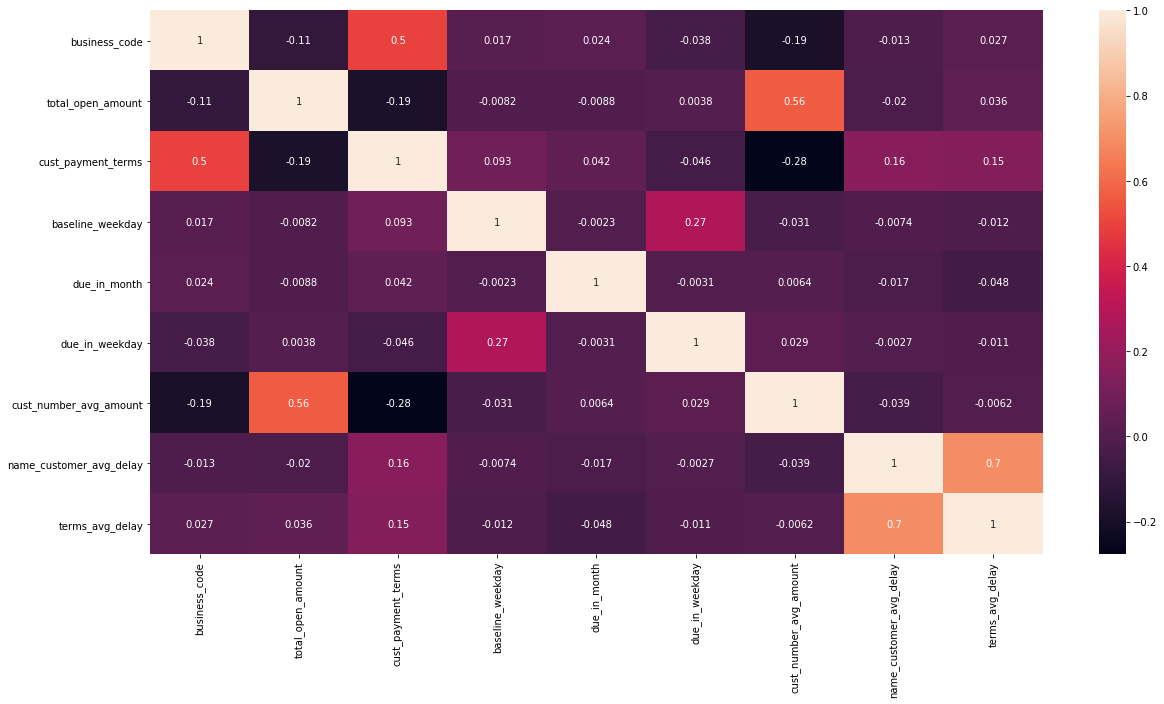

In [72]:
#visualisation
corr=x_train.corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr,annot=True)

In [73]:
#copying back the delay to check corr
x_train['delay']= y_train
x_train.corr().loc['delay',:]


business_code              0.006829
total_open_amount         -0.022585
cust_payment_terms         0.077978
baseline_weekday           0.005442
due_in_month              -0.040776
due_in_weekday             0.011382
cust_number_avg_amount    -0.029134
name_customer_avg_delay    0.691574
terms_avg_delay            0.553142
delay                      1.000000
Name: delay, dtype: float64

In [74]:
x_train.drop('delay',axis=1,inplace=True) #dropping it back

In [75]:
def handling_correlation(x_train,threshold=0.8):
    # creating set to hold the correlated features
    corr_features = set()
    # create the correlation matrix (default to pearson)
    corr_matrix = x_train.corr()
    #code for selecting all correleated features
    for i in range(len(corr_matrix .columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) >threshold:
                colname = corr_matrix.columns[i]
                corr_features.add(colname)
    return list(corr_features)

In [76]:
#in the time of checking co-relation we have to check with target also that's why I am passing out output_label also
handling_correlation(x_train,0.8)

[]

In [77]:
def tree_based_feature_importance(x_train,y_train):
    from sklearn.ensemble import RandomForestRegressor
    # create the random forest model
    model = RandomForestRegressor(n_estimators=120)

    # fit the model to start training.
    model.fit(x_train, y_train)

    # get the importance of the resulting features.
    importances = model.feature_importances_

    # create a data frame for visualization.
    final_df = pd.DataFrame({"Features": x_train.columns, "Importances":importances})
    final_df.set_index('Importances')

    # sort in descending order 
    final_df = final_df.sort_values('Importances',ascending=False)
    
    #visualising feature importance
    pd.Series(model.feature_importances_, index=x_train.columns).nlargest(6).plot(kind='barh')  
    return final_df

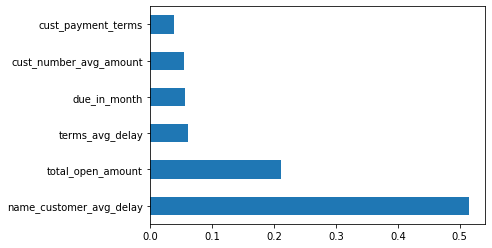

In [78]:
feature_importance=tree_based_feature_importance(x_train,y_train)

In [79]:
display(feature_importance)

,Features,Importances
7,name_customer_avg_delay,0.514956
1,total_open_amount,0.212031
8,terms_avg_delay,0.061256
4,due_in_month,0.055762
6,cust_number_avg_amount,0.055132
2,cust_payment_terms,0.038245
3,baseline_weekday,0.032347
5,due_in_weekday,0.026695
0,business_code,0.003575


In [80]:
#null value impuatation in validation set
x_val['terms_avg_delay'].fillna(x_val['terms_avg_delay'].mean(),inplace=True)
x_val['cust_number_avg_amount'].fillna(x_val['cust_number_avg_amount'].mean(),inplace=True)
x_val['name_customer_avg_delay'].fillna(x_val['name_customer_avg_delay'].mean(),inplace=True)
x_val.isna().mean()


business_code              0.0
total_open_amount          0.0
cust_payment_terms         0.0
baseline_weekday           0.0
due_in_month               0.0
due_in_weekday             0.0
cust_number_avg_amount     0.0
name_customer_avg_delay    0.0
terms_avg_delay            0.0
dtype: float64

In [81]:
#null value impuatation in test set
x_test['terms_avg_delay'].fillna(x_test['terms_avg_delay'].mean(),inplace=True)
x_test['cust_number_avg_amount'].fillna(x_test['cust_number_avg_amount'].mean(),inplace=True)
x_test['name_customer_avg_delay'].fillna(x_val['name_customer_avg_delay'].mean(),inplace=True)
x_test.isna().mean()

business_code              0.0
total_open_amount          0.0
cust_payment_terms         0.0
baseline_weekday           0.0
due_in_month               0.0
due_in_weekday             0.0
cust_number_avg_amount     0.0
name_customer_avg_delay    0.0
terms_avg_delay            0.0
dtype: float64

In [82]:
x_val.head()

,business_code,total_open_amount,cust_payment_terms,baseline_weekday,due_in_month,due_in_weekday,cust_number_avg_amount,name_customer_avg_delay,terms_avg_delay
30476,1,785.64,20,4,9,5,5828.000000,1.000000,2.0
14375,1,76211.84,26,4,9,5,23062.000000,-2.000000,1.0
8286,1,15678.09,20,4,9,5,5828.000000,1.000000,2.0
25316,1,16128.77,20,4,9,5,48180.000000,1.000000,2.0
13455,2,18628.36,23,4,9,4,32583.769562,1.548758,10.0


In [83]:
# Modeling & Accuracy Metrics
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
#import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


In [84]:
x_val.isna().mean()

business_code              0.0
total_open_amount          0.0
cust_payment_terms         0.0
baseline_weekday           0.0
due_in_month               0.0
due_in_weekday             0.0
cust_number_avg_amount     0.0
name_customer_avg_delay    0.0
terms_avg_delay            0.0
dtype: float64

In [85]:
x_test.isna().mean()

business_code              0.0
total_open_amount          0.0
cust_payment_terms         0.0
baseline_weekday           0.0
due_in_month               0.0
due_in_weekday             0.0
cust_number_avg_amount     0.0
name_customer_avg_delay    0.0
terms_avg_delay            0.0
dtype: float64

In [86]:
#Using RandomForestRegressor on validation set
reg = RandomForestRegressor().fit(x_train,y_train)
predicted = reg.predict(x_val)
r2=r2_score(y_val, predicted)
mse=mean_squared_error(y_val, predicted)
rmse = mse**0.5
print("r2 score: ",r2)
print("rmse : ",rmse)

r2 score:  0.2252635315434024
rmse :  7.124483584894877


In [87]:
# standarisation: we use the StandardScaler from sklearn
from sklearn import preprocessing 
scaler = preprocessing.StandardScaler() # create an object
X_train_scaled = scaler.fit_transform(x_train) # fit the scaler to the train set, and then transform it
X_val_scaled = scaler.transform(x_val) # transform the val set

#Using LinearRegressor on validation set
reg = LinearRegression().fit(X_train_scaled,y_train)
predicted = reg.predict(X_val_scaled)
r2=r2_score(y_val, predicted)
mse=mean_squared_error(y_val, predicted)
rmse = mse**0.5
print("r2 score: ",r2)
print("rmse : ",rmse)

r2 score:  0.40146919070347664
rmse :  6.262094910693169


In [88]:
# standarisation: we use the StandardScaler from sklearn
from sklearn import preprocessing 
scaler = preprocessing.StandardScaler() # create an object
X_train_scaled = scaler.fit_transform(x_train) # fit the scaler to the train set, and then transform it
X_val_scaled = scaler.transform(x_val) # transform the val set

#Using SVR() on validation set
reg = SVR().fit(X_train_scaled,y_train)
predicted = reg.predict(X_val_scaled)
r2=r2_score(y_val, predicted)
mse=mean_squared_error(y_val, predicted)
rmse = mse**0.5
print("r2 score: ",r2)
print("rmse : ",rmse)

r2 score:  0.469549356335383
rmse :  5.895204577622217


In [89]:
# standarisation: we use the StandardScaler from sklearn
from sklearn import preprocessing 
scaler = preprocessing.StandardScaler() # create an object
X_train_scaled = scaler.fit_transform(x_train) # fit the scaler to the train set, and then transform it
X_test_scaled = scaler.transform(x_test) # transform the val set

#Using SVR() on TEST set
reg = SVR().fit(X_train_scaled,y_train)
predicted = reg.predict(X_test_scaled)
r2=r2_score(y_test, predicted)
mse=mean_squared_error(y_test, predicted)
rmse = mse**0.5
print("r2 score: ",r2)
print("rmse : ",rmse)

r2 score:  0.39731544438121047
rmse :  7.201010322394348


In [90]:
#copying the dataset with clearing date null into new dataset
x_df2 = df2.copy()
x_df2.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen
45033,U001,200794332,COST,NaT,2020.0,1.930685e+09,2020-03-23,2020-03-21,2020-03-23,2020-04-07,USD,RV,1.0,NaN,14772.55,2020-03-23,NAAX,1.930685e+09,1
45034,U001,0100043975,JAVA,NaT,2020.0,1.930740e+09,2020-04-03,2020-04-03,2020-04-03,2020-04-18,USD,RV,1.0,NaN,1427.36,2020-04-03,NAA8,1.930740e+09,1
45035,CA02,0140106408,WAL-M corporation,NaT,2020.0,2.960627e+09,2020-04-08,2020-04-08,2020-04-08,2020-04-19,CAD,RV,1.0,NaN,53237.81,2020-04-09,CA10,2.960627e+09,1
45036,U001,0200762301,C&S WH trust,NaT,2020.0,1.930705e+09,2020-03-25,2020-03-26,2020-03-25,2020-04-09,USD,RV,1.0,NaN,4604.85,2020-03-25,NAC6,1.930705e+09,1
45037,U001,0200772670,ASSOCIAT associates,NaT,2020.0,1.930827e+09,2020-04-25,2020-04-25,2020-04-25,2020-05-10,USD,RV,1.0,NaN,4331.48,2020-04-25,NAU5,1.930827e+09,1


In [91]:
#finding unique column in this dataset
unique_cols =  [x for x in x_df2.columns if x_df2[x].nunique()<=1] 
print(unique_cols)

['clear_date', 'buisness_year', 'document type', 'posting_id', 'area_business', 'isOpen']


In [92]:
#removing them
x_df2.drop(unique_cols ,axis=1,inplace=True)

In [93]:
x_df2.sort_values(by="document_create_date.1", inplace=True)

In [94]:
#Label encoding 
from sklearn import preprocessing 
label_encoder = preprocessing.LabelEncoder() 
x_df2['business_code']= label_encoder.fit_transform(x_df2['business_code']) 
  
x_df2['business_code'].unique() 

array([1, 0, 4, 2, 3])

In [95]:
#Label encoding
from sklearn import preprocessing 
label_encoder = preprocessing.LabelEncoder() 
x_df2['cust_payment_terms']= label_encoder.fit_transform(x_df2['cust_payment_terms']) 
  
x_df2['cust_payment_terms'].unique()

array([ 8, 22,  2, 10, 13, 20, 21, 35,  5, 17, 33, 32, 27,  9,  4, 34, 24,
       23, 19, 26, 31,  6, 15, 14,  3,  0, 12, 30, 11,  1, 29, 18,  7, 28,
       16, 25])

In [96]:
x_df2['baseline_weekday'] = x_df2['baseline_create_date'].dt.dayofweek

In [97]:
x_df2['due_in_month'] = x_df2['due_in_date'].dt.month

In [98]:
x_df2['due_in_weekday'] = x_df2['due_in_date'].dt.dayofweek

In [99]:
#mapping the features created from the test set
x_df2['cust_number_avg_amount'] = x_df2['cust_number'].map(mapper2).apply(np.ceil)

In [100]:
#mapping the features created from the test set
x_df2['name_customer_avg_delay'] = x_df2['name_customer'].map(mapper4).apply(np.ceil)

In [101]:
#mapping the features created from the test set
x_df2['terms_avg_delay'] = x_df2['cust_payment_terms'].map(mapper5).apply(np.ceil)

In [102]:
#dropping the features which are not supported by model
x_df2=x_df2.drop(['cust_number','name_customer','doc_id','posting_date','document_create_date','document_create_date.1','due_in_date','invoice_currency','baseline_create_date','invoice_id'],axis=1)

In [103]:
x_df2.isna().mean()

business_code              0.000000
total_open_amount          0.000000
cust_payment_terms         0.000000
baseline_weekday           0.000000
due_in_month               0.000000
due_in_weekday             0.000000
cust_number_avg_amount     0.042078
name_customer_avg_delay    0.071673
terms_avg_delay            0.070264
dtype: float64

In [104]:
#null value imputation
x_df2['terms_avg_delay'].fillna(x_df2['terms_avg_delay'].mean(),inplace=True)
x_df2['cust_number_avg_amount'].fillna(x_df2['cust_number_avg_amount'].mean(),inplace=True)
x_df2['name_customer_avg_delay'].fillna(x_df2['name_customer_avg_delay'].mean(),inplace=True)
x_df2.isna().mean()

business_code              0.0
total_open_amount          0.0
cust_payment_terms         0.0
baseline_weekday           0.0
due_in_month               0.0
due_in_weekday             0.0
cust_number_avg_amount     0.0
name_customer_avg_delay    0.0
terms_avg_delay            0.0
dtype: float64

In [105]:
# standarisation: we use the StandardScaler from sklearn
from sklearn import preprocessing 
scaler = preprocessing.StandardScaler() # create an object
X_train_scaled = scaler.fit_transform(x_train) # fit the scaler to the train set, and then transform it
X_df2_scaled = scaler.transform(x_df2) # transform the val set

#Using SVR for modeling
reg = SVR().fit(X_train_scaled,y_train)
#storing predicted values in a new column as predicted delay
x_df2['predicted_delay'] = reg.predict(X_df2_scaled)


In [106]:
x_df2.head()

,business_code,total_open_amount,cust_payment_terms,baseline_weekday,due_in_month,due_in_weekday,cust_number_avg_amount,name_customer_avg_delay,terms_avg_delay,predicted_delay
49377,1,25487.12,8,3,3,4,51861.0,5.0,3.0000,2.549391
45574,1,33826.02,8,3,3,4,46689.0,1.0,3.0000,0.730448
46539,1,73306.40,22,3,3,4,21588.0,-2.0,1.0000,-1.466059
48462,0,58092.26,2,0,3,3,102828.0,6.0,1.5877,2.831737
49855,1,502.08,8,3,3,4,5828.0,1.0,3.0000,2.030726


In [107]:
#copying the predicted delay 
df2['predicted_delay'] = x_df2['predicted_delay']

In [108]:
#creating predicted payment date by adding due date and predicted delay
df2['predicted_payment_date'] = df2['due_in_date'].combine(df2['predicted_delay'], lambda x,y: x + pd.DateOffset(days=int(np.ceil(y))))

In [109]:
df2.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,...,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen,predicted_delay,predicted_payment_date
45033,U001,200794332,COST,NaT,2020.0,1.930685e+09,2020-03-23,2020-03-21,2020-03-23,2020-04-07,...,RV,1.0,NaN,14772.55,2020-03-23,NAAX,1.930685e+09,1,2.450324,2020-04-10
45034,U001,0100043975,JAVA,NaT,2020.0,1.930740e+09,2020-04-03,2020-04-03,2020-04-03,2020-04-18,...,RV,1.0,NaN,1427.36,2020-04-03,NAA8,1.930740e+09,1,2.854110,2020-04-21
45035,CA02,0140106408,WAL-M corporation,NaT,2020.0,2.960627e+09,2020-04-08,2020-04-08,2020-04-08,2020-04-19,...,RV,1.0,NaN,53237.81,2020-04-09,CA10,2.960627e+09,1,8.166044,2020-04-28
45036,U001,0200762301,C&S WH trust,NaT,2020.0,1.930705e+09,2020-03-25,2020-03-26,2020-03-25,2020-04-09,...,RV,1.0,NaN,4604.85,2020-03-25,NAC6,1.930705e+09,1,-1.828346,2020-04-08
45037,U001,0200772670,ASSOCIAT associates,NaT,2020.0,1.930827e+09,2020-04-25,2020-04-25,2020-04-25,2020-05-10,...,RV,1.0,NaN,4331.48,2020-04-25,NAU5,1.930827e+09,1,2.816837,2020-05-13


In [110]:
#Binning
conditions = [
    (df2['predicted_delay'] <= 15)&(df2['predicted_delay']>0),
    (df2['predicted_delay'] <= 30) & (df2['predicted_delay'] > 15),
    (df2['predicted_delay'] <=45) & (df2['predicted_delay'] > 30),
    (df2['predicted_delay'] <= 60) & (df2['predicted_delay'] > 45),
    (df2['predicted_delay'] > 60),
    (df2['predicted_delay']<=0)
    ]
values=['0-15','16-30','31-45','46-60','Greater than 60','Ontime']
df2['PassdueBuckets'] = np.select(conditions, values)

In [111]:
df2.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,...,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen,predicted_delay,predicted_payment_date,PassdueBuckets
45033,U001,200794332,COST,NaT,2020.0,1.930685e+09,2020-03-23,2020-03-21,2020-03-23,2020-04-07,...,1.0,NaN,14772.55,2020-03-23,NAAX,1.930685e+09,1,2.450324,2020-04-10,0-15
45034,U001,0100043975,JAVA,NaT,2020.0,1.930740e+09,2020-04-03,2020-04-03,2020-04-03,2020-04-18,...,1.0,NaN,1427.36,2020-04-03,NAA8,1.930740e+09,1,2.854110,2020-04-21,0-15
45035,CA02,0140106408,WAL-M corporation,NaT,2020.0,2.960627e+09,2020-04-08,2020-04-08,2020-04-08,2020-04-19,...,1.0,NaN,53237.81,2020-04-09,CA10,2.960627e+09,1,8.166044,2020-04-28,0-15
45036,U001,0200762301,C&S WH trust,NaT,2020.0,1.930705e+09,2020-03-25,2020-03-26,2020-03-25,2020-04-09,...,1.0,NaN,4604.85,2020-03-25,NAC6,1.930705e+09,1,-1.828346,2020-04-08,Ontime
45037,U001,0200772670,ASSOCIAT associates,NaT,2020.0,1.930827e+09,2020-04-25,2020-04-25,2020-04-25,2020-05-10,...,1.0,NaN,4331.48,2020-04-25,NAU5,1.930827e+09,1,2.816837,2020-05-13,0-15


In [112]:
a=1
b=2
c=3
print(a," ",b," ",c)

1   2   3


In [114]:
import pickle
filename = '1806291.pkl'
pickle.dump(reg, open(filename, 'wb'))
